In [63]:
# Parameters
M = 200           # Number of initial bacteria (lineages)
N = 10            # Number of generations
p = 1e-3          # Mutation probability per division
num_simulations = 500  # Number of simulation runs

## Random Mutations Only

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def simulate_ld(M, N, p):
    resilient_count = 0
    for _ in range(M):
        mutated = False
        cells = 1
        for _ in range(N):
            new_cells = 0
            for _ in range(cells):
                if mutated:
                    new_cells += 2
                else:
                    if np.random.rand() < p:
                        mutated = True
                    new_cells += 2
            cells = new_cells
        if mutated:
            resilient_count += cells
    return resilient_count / (M * (2 ** N))

# Simulations
simulated_fractions = [simulate_ld(M, N, p) for _ in tqdm(range(num_simulations), desc="Simulating")]


Simulating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:31<00:00, 16.02it/s]


In [65]:
# Compute analytical probabilities
D = 2**N - 1
q = 1 - (1 - p)**D
ks = np.arange(0, M+1)
analytic_probs = np.array([np.math.comb(M, k) * (q**k) * ((1-q)**(M-k)) for k in ks])
analytic_fractions = ks / M

C:\Users\Yuval\AppData\Local\Temp\ipykernel_4308\1426562499.py:5: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  analytic_probs = np.array([np.math.comb(M, k) * (q**k) * ((1-q)**(M-k)) for k in ks])


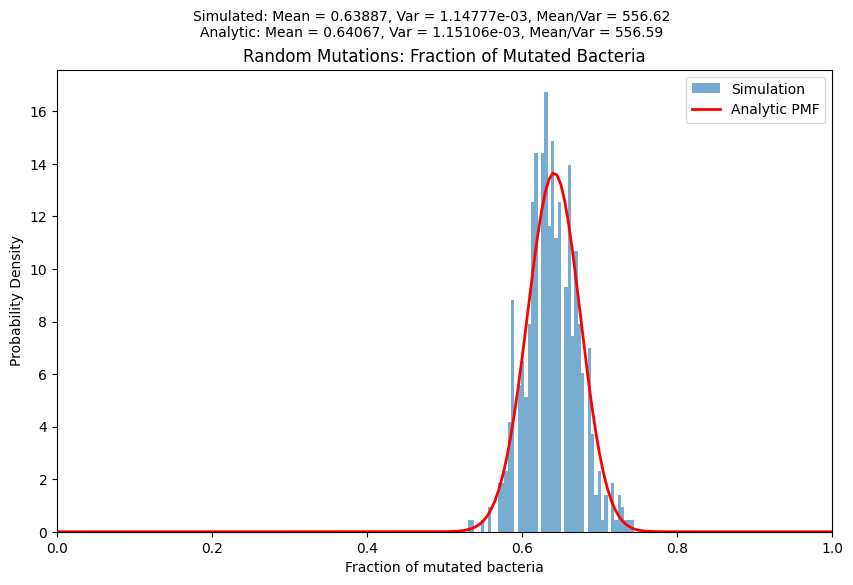

In [71]:
# Determine bin width from the histogram
bin_count = 50
hist_vals, bin_edges = np.histogram(simulated_fractions, bins=bin_count, density=True)
bin_width = bin_edges[1] - bin_edges[0]

# Scale analytic PMF to match histogram scaling
analytic_probs_scaled = analytic_probs / bin_width

# Calculate mean, variance, and their ratio for the simulation.
sim_mean = np.mean(simulated_fractions)
sim_var = np.var(simulated_fractions)
ratio_sim = sim_mean / sim_var if sim_var != 0 else np.nan

# Calculate the analytic mean and variance.
analytic_mean = np.sum(analytic_fractions * analytic_probs)
analytic_var = np.sum((analytic_fractions**2) * analytic_probs) - analytic_mean**2
ratio_analytic = analytic_mean / analytic_var if analytic_var != 0 else np.nan

# Create a subtitle with the computed values.
subtitle = (
    f"Simulated: Mean = {sim_mean:.5f}, Var = {sim_var:.5e}, Mean/Var = {ratio_sim:.2f}\n"
    f"Analytic: Mean = {analytic_mean:.5f}, Var = {analytic_var:.5e}, Mean/Var = {ratio_analytic:.2f}"
)

# Plot both on the same graph
plt.figure(figsize=(10, 6))
plt.hist(simulated_fractions, bins=bin_count, density=True, alpha=0.6, label='Simulation')
plt.plot(analytic_fractions, analytic_probs_scaled, 'r-', linewidth=2, label='Analytic PMF')

plt.xlabel('Fraction of mutated bacteria')
plt.ylabel('Probability Density')
plt.title('Random Mutations: Fraction of Mutated Bacteria')
plt.suptitle(subtitle, fontsize=10)
plt.legend()
plt.xlim([0, 1])
plt.show()

## Induced Mutations Only

In [75]:
# Parameters
M = 1000           # Number of initial bacteria (lineages)
N = 10            # Number of generations
p = 5e-3          # Mutation probability per division
num_simulations = 3000  # Number of simulation runs


Simulating Induced: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 583623.01it/s]
C:\Users\Yuval\AppData\Local\Temp\ipykernel_4308\3299148515.py:25: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  analytic_probs = np.array([np.exp(-lambda_ind) * (lambda_ind**k) / np.math.factorial(k) for k in k_values])


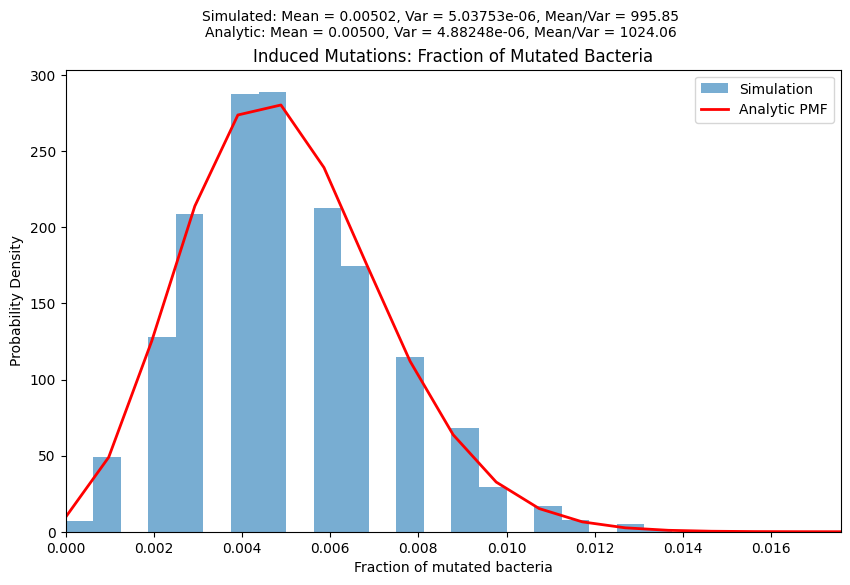

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# For induced mutations, we simulate one colony at a time.
def simulate_induced():
    # Each colony has 2**N cells. After growth, mutations are induced.
    # Count number of mutants via a binomial draw.
    mutants = np.random.binomial(n=2**N, p=p)
    return mutants / (2**N)

# Run many simulation trials (each trial is one colony)
simulated_fractions_induced = [simulate_induced() for _ in tqdm(range(num_simulations), desc="Simulating Induced")]

# Analytic prediction:
# For each colony, the number of mutants is Poisson distributed with lambda = 2**N * p.
lambda_ind = (2**N) * p

# We choose a range of k-values that covers nearly all the probability mass.
k_min = 0
k_max = int(lambda_ind + 6 * np.sqrt(lambda_ind))
k_values = np.arange(k_min, k_max+1)

# Compute the Poisson PMF for k mutants.
analytic_probs = np.array([np.exp(-lambda_ind) * (lambda_ind**k) / np.math.factorial(k) for k in k_values])
# Convert mutant counts to fractions.
analytic_fractions = k_values / (2**N)

# Determine bin width from the histogram
bin_count = 25
hist_vals, bin_edges = np.histogram(simulated_fractions_induced, bins=bin_count, density=True)
bin_width = bin_edges[1] - bin_edges[0]

# Scale analytic PMF to match histogram scaling
analytic_probs_scaled = analytic_probs / bin_width

# Calculate mean, variance, and ratio for the simulation.
sim_mean = np.mean(simulated_fractions_induced)
sim_var = np.var(simulated_fractions_induced)
ratio_sim = sim_mean / sim_var if sim_var != 0 else np.nan

# Calculate the analytic mean and variance using the discrete PMF.
analytic_mean = np.sum(analytic_fractions * analytic_probs)
analytic_var = np.sum((analytic_fractions**2) * analytic_probs) - analytic_mean**2
ratio_analytic = analytic_mean / analytic_var if analytic_var != 0 else np.nan

# Create a subtitle with the computed values.
subtitle = (
    f"Simulated: Mean = {sim_mean:.5f}, Var = {sim_var:.5e}, Mean/Var = {ratio_sim:.2f}\n"
    f"Analytic: Mean = {analytic_mean:.5f}, Var = {analytic_var:.5e}, Mean/Var = {ratio_analytic:.2f}"
)

# Plot both the simulation histogram and the analytic line.
plt.figure(figsize=(10, 6))

plt.hist(simulated_fractions_induced, bins=bin_count, density=True, alpha=0.6, label='Simulation')
plt.plot(analytic_fractions, analytic_probs_scaled, 'r-', linewidth=2, label='Analytic PMF')

plt.xlabel('Fraction of mutated bacteria')
plt.ylabel('Probability Density')
plt.title('Induced Mutations: Fraction of Mutated Bacteria')
plt.suptitle(subtitle, fontsize=10)
plt.legend()
plt.xlim([0, max(analytic_fractions[-1], np.max(simulated_fractions_induced))])
plt.show()